# Multi-fidelity Multi-objective Bayesian Optimization

Here we attempt to solve for the constrained Pareto front of the TNK multi-objective
optimization problem using Multi-Fidelity Multi-Objective Bayesian optimization. For
simplicity we assume that the objective and constraint functions at lower fidelities is
exactly equal to the functions at higher fidelities (this is obviously not a
requirement, although for the best results lower fidelity calculations should
correlate with higher fidelity ones). The algorithm should learn this relationship
and use information gathered at lower fidelities to gather samples to improve the
hypervolume of the Pareto front at the maximum fidelity.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
%reset -f

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

evaluator = Evaluator(function=evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {}}


## Set up the Multi-Fidelity Multi-objective optimization algorithm
Here we create the Multi-Fidelity generator object which can solve both single and
multi-objective optimization problems depending on the number of objectives in VOCS.
We specify a cost function as a function of fidelity parameter $s=[0,1]$ as $C(s) =
s^{3.5}$ as an example from a real life multi-fidelity simulation problem.

In [2]:
options = MultiFidelityGenerator.default_options()
options.acq.reference_point = {"y1":1.5,"y2":1.5}

# set cost function according to approximate scaling of laser plasma accelerator
# problem, see https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.013063
options.acq.cost_function = lambda s: s**3.5
options.optim.num_restarts = 8
options.optim.raw_samples = 512

generator = MultiFidelityGenerator(tnk_vocs, options)
X = Xopt(generator=generator, evaluator=evaluator, vocs=tnk_vocs)

# evaluate at some explicit initial points
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0],"s":[0.0,0.1]}))

X.generator.options.dict()

{'optim': {'num_restarts': 8,
  'raw_samples': 512,
  'sequential': True,
  'max_travel_distances': None,
  'use_turbo': False},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'cost_function': <function __main__.<lambda>(s)>,
  'reference_point': {'y1': 1.5, 'y2': 1.5}},
 'model': {'name': 'standard',
  'custom_constructor': None,
  'use_low_noise_prior': True,
  'covar_modules': {},
  'mean_modules': {},
  'fidelity_parameter': 's'},
 'n_initial': 3,
 'use_cuda': False}

## Run optimization routine
Instead of ending the optimization routine after an explict number of samples we end
optimization once a given optimization budget has been exceeded. WARNING: This will
slightly exceed the given budget

In [3]:
budget = 10
while X.generator.calculate_total_cost() < budget:
    X.step()
    print(f"n_samples: {len(X.data)} "
          f"budget used: {X.generator.calculate_total_cost():.4} "
          f"hypervolume: {X.generator.calculate_hypervolume():.4}")

n_samples: 3 budget used: 0.009293 hypervolume: 0.0375
n_samples: 4 budget used: 0.01115 hypervolume: 0.0375
n_samples: 5 budget used: 0.0181 hypervolume: 0.0375
n_samples: 6 budget used: 0.0281 hypervolume: 0.0375
n_samples: 7 budget used: 0.0381 hypervolume: 0.1502
n_samples: 8 budget used: 0.06593 hypervolume: 0.1502
n_samples: 9 budget used: 0.08262 hypervolume: 0.2287
n_samples: 10 budget used: 0.1079 hypervolume: 0.2836
n_samples: 11 budget used: 0.1506 hypervolume: 0.3438
n_samples: 12 budget used: 0.2178 hypervolume: 0.3967
n_samples: 13 budget used: 0.3021 hypervolume: 0.431
n_samples: 14 budget used: 0.4521 hypervolume: 0.5075
n_samples: 15 budget used: 0.4782 hypervolume: 0.5075
n_samples: 16 budget used: 0.7361 hypervolume: 0.5744
n_samples: 17 budget used: 0.7501 hypervolume: 0.61
n_samples: 18 budget used: 1.12 hypervolume: 0.6845
n_samples: 19 budget used: 1.659 hypervolume: 0.7846
n_samples: 20 budget used: 2.467 hypervolume: 0.7846
n_samples: 21 budget used: 3.164 hype

## Show results

In [4]:
X.data

,x1,x2,s,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.750000,0.000000,1.000000,0.750000,0.626888,0.312500,"[1, 2, 3]",0.000059,False,NaN
2,0.750000,1.000000,0.100000,0.750000,1.000000,0.626888,0.312500,"[1, 2, 3]",0.000012,False,NaN
3,0.117211,1.409357,0.260126,0.117211,1.409357,0.975944,0.973458,"[1, 2, 3]",0.000040,False,dummy_constant
4,1.196595,1.681207,0.165721,1.196595,1.681207,3.347349,1.880494,"[1, 2, 3]",0.000041,False,dummy_constant
5,0.223782,0.709246,0.241772,0.223782,0.709246,-0.464574,0.120081,"[1, 2, 3]",0.000042,False,dummy_constant
6,0.359479,0.944211,0.268270,0.359479,0.944211,-0.068722,0.217070,"[1, 2, 3]",0.000041,False,dummy_constant
7,0.375628,1.002523,0.268270,0.375628,1.002523,0.060755,0.267997,"[1, 2, 3]",0.000042,False,dummy_constant
8,0.845204,0.312995,0.359420,0.845204,0.312995,-0.269709,0.154136,"[1, 2, 3]",0.000044,False,dummy_constant
9,1.125715,0.394562,0.310557,1.125715,0.394562,0.359916,0.402637,"[1, 2, 3]",0.000042,False,dummy_constant
10,1.009209,0.340863,0.349751,1.009209,0.340863,0.086821,0.284619,"[1, 2, 3]",0.000042,False,dummy_constant


## Plot results
Here we plot the resulting observations in input space, colored by feasibility
(neglecting the fact that
these data points are at varying fidelities).


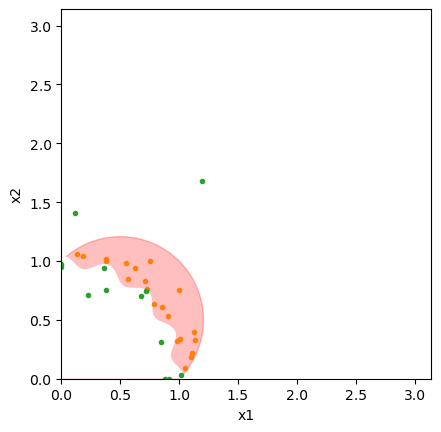

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

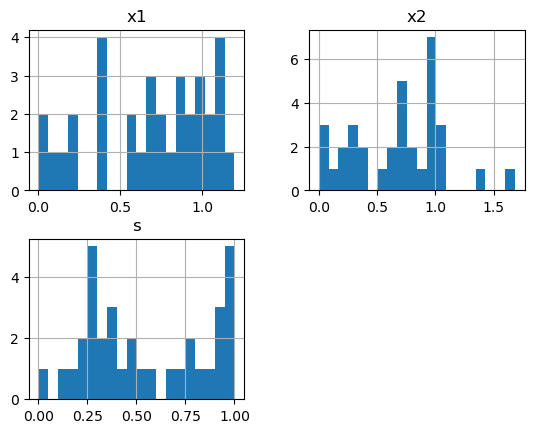

In [6]:
ax = history.hist(["x1", "x2", "s"],bins=20)

<Axes: >

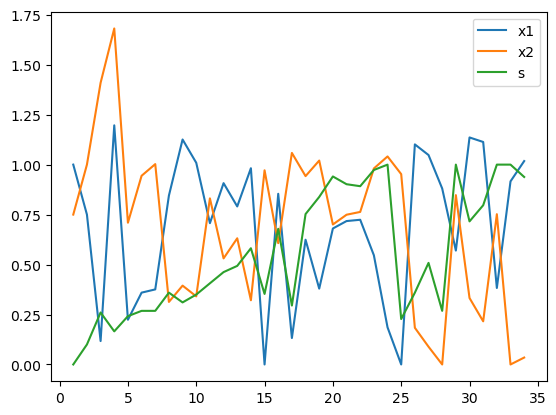

In [7]:
history.plot(y=["x1", "x2", "s"])

## Plot the acqusisition function
Here we plot the acquisition function at a small set of fidelities $[0, 0.5, 1.0]$.

[[1.05172457 0.08111208]]


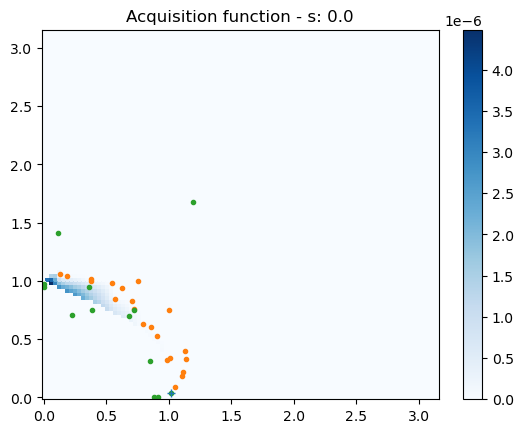

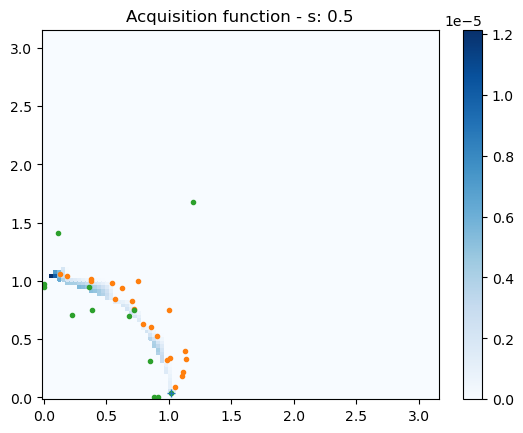

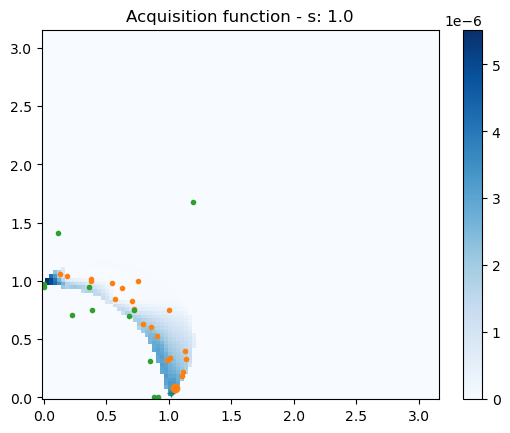

In [8]:
# plot the acquisition function
from xopt.generators.bayesian.objectives import feasibility

bounds = generator.vocs.bounds
model = generator.model

# create mesh over non-fidelity parameters
n = 100
x = torch.linspace(*bounds.T[1], n)
y = torch.linspace(*bounds.T[2], n)
xx, yy = torch.meshgrid(x, y)

# plot function(s) at a single fidelity parameter
fidelities = [0.0, 0.5, 1.0]
for fidelity in fidelities:
    pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()
    pts = torch.cat((torch.ones(pts.shape[0],1)*fidelity, pts), dim=-1)

    acq_func = generator.get_acquisition(model)
    with torch.no_grad():
        acq_pts = pts.unsqueeze(1)
        acq = acq_func(acq_pts)

        fig, ax = plt.subplots()
        c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
        fig.colorbar(c)
        ax.set_title(f"Acquisition function - s: {fidelity}")

        ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
        ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

        ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")


candidate = generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

In [9]:
# examine lengthscale of the first objective
list(model.models[0].named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-26.8007], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(-0.0586, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0.6305, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0.8154, 1.4270, 1.5814]], dtype=torch.float64, requires_grad=True))]

In [10]:
# dump results to fiel
X.options.dump_file = "results.yaml"
X.dump_state()